# Online Retail — Plots **without log scales** (Aidan)

This notebook recreates two analyses **on raw (non-log) axes**:

1. **Top-10 SKUs by Revenue** — bar chart  

2. **Unit Price vs. Quantity** — scatter plot with a **binned-average trend line**


> **Note:** This version intentionally **does not** call `plt.xscale('log')` or `plt.yscale('log')`.
It is ready to run with your dataset (CSV or Excel).


In [1]:
# Imports
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For optional Colab upload
try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)


Matplotlib is building the font cache; this may take a moment.


## Load your data

Choose one of the two options below:

- **Option A (Local path):** set `DATA_PATH` to your file (CSV or XLSX).
- **Option B (Colab upload):** leave `DATA_PATH=None` and run; you'll be prompted to upload.


In [2]:
import pandas as pd
import io, os

# Detect Colab
try:
    from google.colab import files  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

DEFAULT_NAME = "online_retail_sample_10k_clean.csv"  # change if needed

def _read_any(path_or_buf, filename_hint=""):
    """Read CSV/CSV.GZ/Excel into a DataFrame."""
    name = (filename_hint or (str(path_or_buf) if isinstance(path_or_buf, str) else ""))
    lower = name.lower()
    if lower.endswith((".xlsx", ".xls")):
        return pd.read_excel(path_or_buf)
    comp = "gzip" if lower.endswith(".gz") else "infer"
    return pd.read_csv(path_or_buf, compression=comp, low_memory=False, encoding="latin1")

# ==== PROMPT & LOAD ====
if os.path.exists(DEFAULT_NAME):
    print(f"Found {DEFAULT_NAME} in the working directory. Loading it…")
    df_raw = _read_any(DEFAULT_NAME, filename_hint=DEFAULT_NAME)

elif IN_COLAB:
    print("Please upload your CSV / CSV.GZ / XLSX file…")
    uploaded = files.upload()
    if not uploaded:
        raise SystemExit("No file uploaded.")
    name, data = next(iter(uploaded.items()))
    buf = io.BytesIO(data)
    df_raw = _read_any(buf, filename_hint=name)
    print(f"Loaded: {name}  -> shape={df_raw.shape}")

else:
    # Local Jupyter: file dialog with fallback to manual path
    path = ""
    try:
        import tkinter as tk
        from tkinter import filedialog
        tk.Tk().withdraw()
        path = filedialog.askopenfilename(
            title="Select CSV/CSV.GZ or Excel file",
            filetypes=[("CSV", "*.csv"), ("Compressed CSV", "*.csv.gz"),
                       ("Excel", "*.xlsx *.xls"), ("All files", "*.*")]
        )
    except Exception:
        pass
    if not path:
        path = input("Enter path to your CSV/CSV.GZ or Excel file: ").strip()
    if not path:
        raise SystemExit("No file selected.")
    df_raw = _read_any(path, filename_hint=os.path.basename(path))
    print(f"Loaded: {os.path.basename(path)}  -> shape={df_raw.shape}")

print("Initial shape:", df_raw.shape)
df_raw.head(3)


Found online_retail_sample_10k_clean.csv in the working directory. Loading it…
Initial shape: (9783, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom,20.4
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom,27.8
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom,2.6


## Clean the data

- Remove credit notes (InvoiceNo starting with 'C') if present  
- Keep only positive quantities and prices  
- Drop rows missing the SKU/StockCode


In [3]:
df = df_raw.copy()

def _find_col(df, options):
    for c in df.columns:
        if c.lower() in [o.lower() for o in options]:
            return c
    return None

sku_col = _find_col(df, ['StockCode', 'SKU', 'stockcode', 'sku'])
if sku_col is None:
    raise ValueError('Could not find a SKU column. Expected one of: StockCode, SKU')

invoice_col = _find_col(df, ['InvoiceNo', 'Invoice'])
qty_col     = _find_col(df, ['Quantity', 'Qty'])
price_col   = _find_col(df, ['UnitPrice', 'Price'])
if qty_col is None or price_col is None:
    raise ValueError("Could not find quantity/price columns. Need 'Quantity' & 'UnitPrice' (or 'Qty'/'Price').")

if invoice_col is not None:
    df[invoice_col] = df[invoice_col].astype(str)
    df = df[~df[invoice_col].str.startswith('C', na=False)]

df = df[(df[qty_col] > 0) & (df[price_col] > 0)]
df = df.dropna(subset=[sku_col]).copy()

df['Revenue'] = df[qty_col] * df[price_col]

print(df.shape)
df.head(3)


(9783, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom,20.4
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom,27.8
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom,2.6


## Q1 — Top-10 SKUs by Revenue (raw scale)

Aggregate revenue per SKU and plot the top 10.


,StockCode,Revenue
241,21175,3656.13
2234,85099B,3055.72
1903,47566,2116.05
912,22423,1827.44
2236,85099F,1799.56
1171,22728,1732.46
798,22273,1706.15
685,22112,1513.86
2242,85123A,1195.10
1173,22730,1125.87


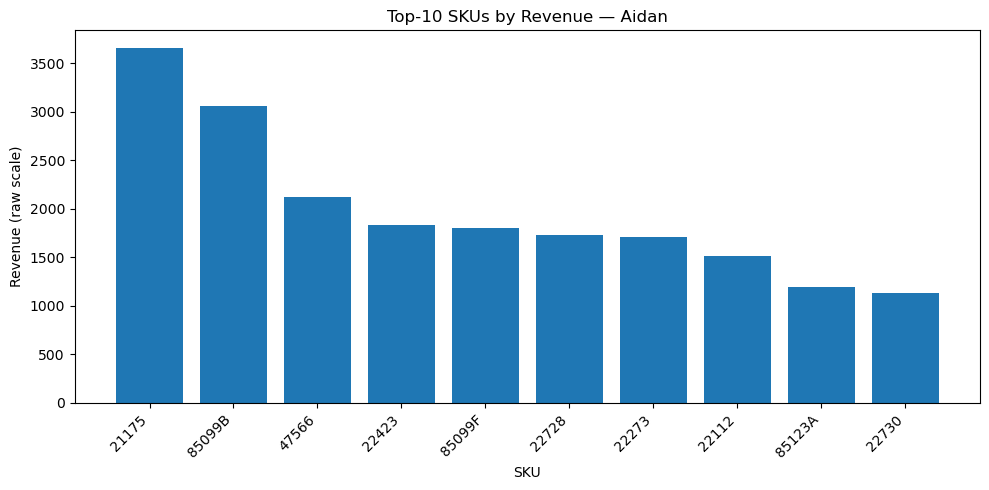

In [4]:
topn = 10
revenue_by_sku = (
    df.groupby(sku_col, as_index=False)['Revenue']
      .sum()
      .sort_values('Revenue', ascending=False)
      .head(topn)
)

display(revenue_by_sku)

plt.figure(figsize=(10, 5))
plt.bar(revenue_by_sku[sku_col].astype(str), revenue_by_sku['Revenue'])
plt.title('Top-10 SKUs by Revenue — Aidan')
plt.xlabel('SKU')
plt.ylabel('Revenue (raw scale)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Q2 — Unit Price vs Quantity (raw axes)

Scatter individual line-items (**no log scales**) and overlay a **binned-average** line to show the typical quantity sold at similar price levels.


Points plotted: 9630


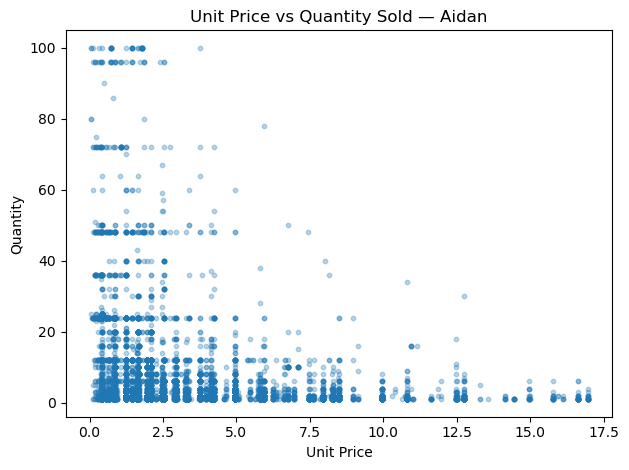

In [6]:
# Scatter: UnitPrice vs Quantity (clip extreme outliers to see the pattern)
req = {"UnitPrice","Quantity"}
if not req.issubset(df.columns):
    raise ValueError(f"Missing columns: {req - set(df.columns)}")

tmp = df[(df["UnitPrice"] > 0) & (df["Quantity"] > 0)].copy()

# Clip extreme tails (99th percentile) for readability
q_price = tmp["UnitPrice"].quantile(0.99)
q_qty = tmp["Quantity"].quantile(0.99)
tmp = tmp[(tmp["UnitPrice"] <= q_price) & (tmp["Quantity"] <= q_qty)]

print("Points plotted:", len(tmp))

fig, ax = plt.subplots()
ax.scatter(tmp["UnitPrice"], tmp["Quantity"], alpha=0.3, s=10)
ax.set_title("Unit Price vs Quantity Sold — Aidan")
ax.set_xlabel("Unit Price")
ax.set_ylabel("Quantity")
plt.tight_layout()
plt.show()




### Interpretation (raw-scale view)

- The scatter shows **actual units** for both price and quantity.
- The **binned-average line** smooths noise to show typical quantities at similar price levels.
- Correlations are reported on raw data (no logs).
- If elasticity is needed, a separate log–log analysis is recommended; this notebook intentionally avoids logs per your request.
